## LSTMでsin波を予測する

In [1]:
import datetime
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from numpy.random import *

In [28]:
EPOCH_NUM = 300
HIDDEN_SIZE = 5
BATCH_SIZE = 100 # 分割した時系列をいくつミニバッチに取り込むか
INPUT_LENGTH = 10 # ミニバッチで分割する時系列数

# 教師データ
train_data = np.array([np.sin(i*2*np.pi/50) for i in range(50)]*10)
rand_vector=randn(500)*0.05
# train_data=train_data+rand_vector
# 教師データを変換
train_x, train_t = [], []
for i in range(0, len(train_data)-INPUT_LENGTH):
    train_x.append(train_data[i:i+INPUT_LENGTH])
    train_t.append(train_data[i+INPUT_LENGTH])
train_x = np.array(train_x, dtype="float32")
train_t = np.array(train_t, dtype="float32")
N = len(train_x)

train_x=train_x.reshape(N,INPUT_LENGTH,1)#これしないと(data_num, sep_len, )となってしまう
train_t=train_t.reshape(N,1)
print(train_data.shape)
print(train_x.shape)
print(train_t.shape)

(500,)
(490, 10, 1)
(490, 1)


クラス定義
lstmの出力が、シーケンスででてくるけど、欲しいのは最終セルの出力だけなんだよなあ

=>torch.nn.LSTMの出力はoutputs,(h_n,c_n)で返ってくるぽくて、outputsは隠れ層の出力のリスト(h_tがシーケンス長分)、h_nは最終セルの隠れ層の出力、c_nは最終セルの状態ベクトルなので、h_nを使えばいい。

h_nは(層の数*方向の数 , バッチサイズ , 隠れ層の次元)
で返ってくる。普通はひとつめの次元は1だからsqueezeとかreshapeをして(バッチサイズ, 隠れ層の次元)に調整しておく必要がある。

In [29]:
class SinLstm(nn.Module):
    def __init__(self, seq_size, hidden_size, out_size,batch_size):
        # クラスの初期化
        # :param seq_size: 入力時系列のサイズ
        # :param hidden_size: 隠れ層のサイズ(LSTMの出力次元)
        # :param out_size: 出力層のサイズ
        super(SinLstm, self).__init__()
        self.lstm = torch.nn.LSTM(hidden_size= hidden_size,input_size=1,batch_first=True)
        self.dense= torch.nn.Linear(hidden_size, out_size)
        self.hidden_size = hidden_size
        self.batch_size=batch_size

    def forward(self, x):
        # x: 入力時系列
        outputs, self.hidden = self.lstm(x,self.hidden)
        y=self.dense(outputs[:,-1,:])
        return y

    def reset_state(self,x):
        batch_size=x.size(0)
        # メモリの初期化
        self.hidden = (Variable(torch.zeros(1, batch_size, self.hidden_size)), Variable(torch.zeros(1, batch_size, self.hidden_size))) # h, c
            

In [30]:
model = SinLstm(seq_size=INPUT_LENGTH, hidden_size=HIDDEN_SIZE, out_size=1,batch_size=BATCH_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
print(model)

SinLstm(
  (lstm): LSTM(1, 5, batch_first=True)
  (dense): Linear(in_features=5, out_features=1, bias=True)
)


In [31]:
# 学習開始
print("Train")
for epoch in range(EPOCH_NUM):
    # ミニバッチ学習
    x, t = [], []
    #  ミニバッチ学習データとして、BATCH_SIZE個用意する
    for i in range(BATCH_SIZE):
        index = np.random.randint(0, N) # ランダムな箇所
        x.append(train_x[index]) # INPUT_LENGTH分の時系列を取り出す
        t.append(train_t[index])
    total_loss = 0
    x = np.array(x, dtype="float32")
    t = np.array(t, dtype="float32")
    x = Variable(torch.from_numpy(x))
    t = Variable(torch.from_numpy(t))
    model.reset_state(x) # メモリの初期化
    y = model(x)#xのshapeは(batch_size, seq_len, input_dim)となっていなければいけない
    loss = criterion(y, t)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
    if (epoch+1) % 100 == 0:
        ed = datetime.datetime.now()
        print("epoch:{} \t total loss: {}".format(epoch+1, total_loss))

Train
epoch:100 	 total loss: 0.28448864817619324
epoch:200 	 total loss: 0.12346319109201431
epoch:300 	 total loss: 0.07800944149494171


#### 真の入力系列を用いて次の値を予測する

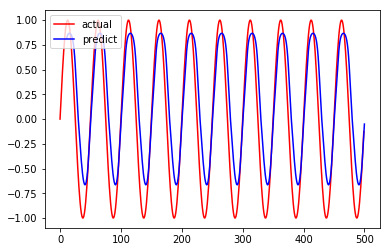

In [37]:
predict = np.empty(0) # 予測時系列

model.batch_size=1


for i in range(len(train_data) - INPUT_LENGTH):
    model.reset_state(x) # メモリを初期化
    x = np.array([train_data[i:i+INPUT_LENGTH]], dtype="float32")
    x=x.reshape(1,INPUT_LENGTH,1)
    x = Variable(torch.from_numpy(x))
    y = model(x)
    y = y.data.numpy().reshape(1)[0]
    predict = np.append(predict, y)
    
plt.plot(range(len(train_data)), train_data, color="red", label="actual")
plt.plot(range(INPUT_LENGTH+1, len(train_data)+1), predict, color="blue", label="predict")
plt.legend(loc="upper left")
plt.show()
 


#### 予測したデータを使って次の値を予測する

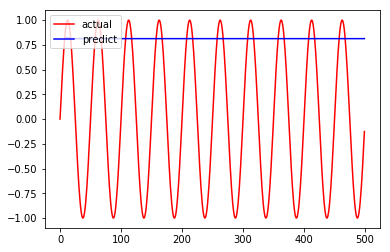

In [38]:
inseq = train_data[:INPUT_LENGTH].reshape(INPUT_LENGTH,1) # 予測直前までの時系列
predict = np.empty(0) # 予測時系列

for _ in range(len(train_data) - INPUT_LENGTH):
    model.reset_state(x) # メモリを初期化
    x = np.array([inseq], dtype="float32")
    x = Variable(torch.from_numpy(x))
    y = model(x)
    y = y.data.numpy().reshape(1)[0]
    predict = np.append(predict, y)
    inseq=np.append(inseq,[[y]],axis=0)
    inseq=np.delete(inseq,0,axis=0)
    
plt.plot(range(len(train_data)), train_data, color="red", label="actual")
plt.plot(range(INPUT_LENGTH, len(train_data)), predict, color="blue", label="predict")
plt.legend(loc="upper left")
plt.show()
 
